# Image Captioning EDA
Ananya Chattoraj

cananya53@gmail.com

### Introduction to the Dataset
The dataset is the Flickr 8k images + captions dataset from Kaggle found [here](https://www.kaggle.com/datasets/aladdinpersson/flickr8kimagescaptions).

### EDA Process
Since this dataset contains both visual and natural language data, I will first split up their EDA. 

Beginning with natural language data, the captions, I will observe the frequency of words to gauge the types of content available within the images (assuming the captions are in fact, reflective of the images).

THEN MORE STUFF

Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from PIL import Image
import os
import random
import glob

Load in the captions as a data frame

In [38]:
caption = pd.read_csv('flickr8k/captions.txt')
caption.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [39]:
caption.shape

(40455, 2)

In [40]:
caption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [41]:
caption.isna().sum()

image      0
caption    0
dtype: int64

Thankfully, this is already a relatively clean caption set in the sense of missing values. The text will still need to be cleaned in the sense of preprocessing.

## IMAGES

In [12]:
#getting image files
imagefolder = 'flickr8k/images/'

In [34]:
#list of all image paths
imagefiles = glob.glob(imagefolder + '/*.jpg')
imagefiles

['flickr8k/images\\1000268201_693b08cb0e.jpg',
 'flickr8k/images\\1001773457_577c3a7d70.jpg',
 'flickr8k/images\\1002674143_1b742ab4b8.jpg',
 'flickr8k/images\\1003163366_44323f5815.jpg',
 'flickr8k/images\\1007129816_e794419615.jpg',
 'flickr8k/images\\1007320043_627395c3d8.jpg',
 'flickr8k/images\\1009434119_febe49276a.jpg',
 'flickr8k/images\\1012212859_01547e3f17.jpg',
 'flickr8k/images\\1015118661_980735411b.jpg',
 'flickr8k/images\\1015584366_dfcec3c85a.jpg',
 'flickr8k/images\\101654506_8eb26cfb60.jpg',
 'flickr8k/images\\101669240_b2d3e7f17b.jpg',
 'flickr8k/images\\1016887272_03199f49c4.jpg',
 'flickr8k/images\\1019077836_6fc9b15408.jpg',
 'flickr8k/images\\1019604187_d087bf9a5f.jpg',
 'flickr8k/images\\1020651753_06077ec457.jpg',
 'flickr8k/images\\1022454332_6af2c1449a.jpg',
 'flickr8k/images\\1022454428_b6b660a67b.jpg',
 'flickr8k/images\\1022975728_75515238d8.jpg',
 'flickr8k/images\\102351840_323e3de834.jpg',
 'flickr8k/images\\1024138940_f1fefbdce1.jpg',
 'flickr8k/image

In [26]:
#I'll want to see some of the images, so define function to display them
def display_image(ipath):
    image = Image.open(ipath)
    plt.imshow(image)
    plt.show()

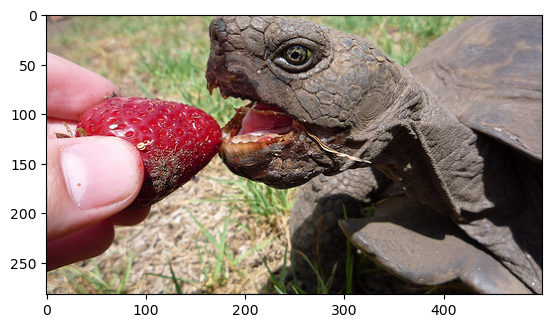

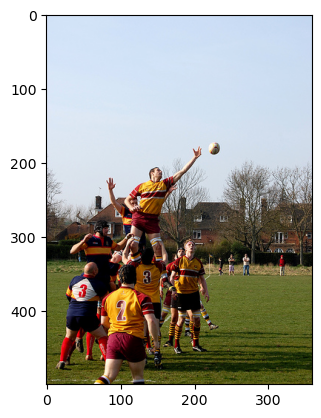

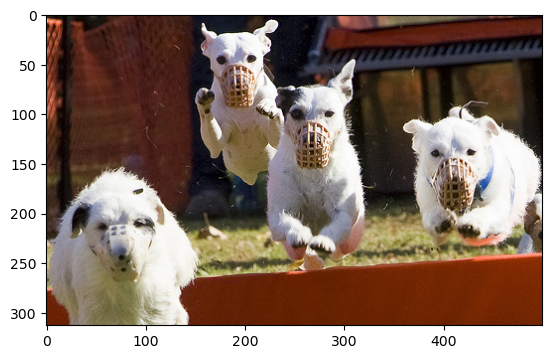

In [35]:
#display 3 random images for sanity check 
randomimages = random.sample(imagefiles,3)
for r in randomimages:
    display_image(r)


In [43]:
ipathsdf = pd.DataFrame({'paths':imagefiles})
ipathsdf.head()

,paths
0,flickr8k/images\1000268201_693b08cb0e.jpg
1,flickr8k/images\1001773457_577c3a7d70.jpg
2,flickr8k/images\1002674143_1b742ab4b8.jpg
3,flickr8k/images\1003163366_44323f5815.jpg
4,flickr8k/images\1007129816_e794419615.jpg


In [44]:
ipathsdf['image'] = ipathsdf['paths'].apply(lambda path: path.split('\\')[-1])
ipathsdf.head()

,paths,image
0,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg
1,flickr8k/images\1001773457_577c3a7d70.jpg,1001773457_577c3a7d70.jpg
2,flickr8k/images\1002674143_1b742ab4b8.jpg,1002674143_1b742ab4b8.jpg
3,flickr8k/images\1003163366_44323f5815.jpg,1003163366_44323f5815.jpg
4,flickr8k/images\1007129816_e794419615.jpg,1007129816_e794419615.jpg


In [45]:
mergeddf = ipathsdf.merge(caption, on='image', how='left')

In [46]:
mergeddf.head()

,paths,image,caption
0,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [47]:
mergeddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   paths    40455 non-null  object
 1   image    40455 non-null  object
 2   caption  40455 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [48]:
#checkpoint
mergeddf.to_pickle('image_captions')